In [1]:
import numpy as np
import tensorflow as tf
import urllib
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import os
import glob
from tensorflow import keras
import random
from time import sleep
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.color import rgba2rgb
from skimage import data
from numpy.random.mtrand import rand
%matplotlib inline

In [2]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2022-03-20 10:08:50--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt.1’

mini_classes.txt.1  100%[===================>]     760  --.-KB/s    in 0s      

2022-03-20 10:08:51 (28.8 MB/s) - ‘mini_classes.txt.1’ saved [760/760]



In [3]:
with open("mini_classes.txt","r") as f:
    classes = f.read()
    f.close()
classes = classes.split('\n')

In [4]:
def black_and_white(img):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i][j] > 0:
        img[i][j] = 1
      else: 
        img[i][j] = 0

  return img


In [5]:
base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
os.mkdir('dataset')
for c in classes:
        cls_url = c.replace('_', '%20')
        path = base + cls_url + '.npy'
        try:
          urllib.request.urlretrieve(path, 'dataset/'+c+'.npy')
        except:
          print(cls_url)

FileExistsError: ignored

In [8]:
def get_data(start_point,end_point,max_items=4000,tratio=0.2):

  all_files = os.listdir('dataset/')
  all_files = ['dataset/' + i for i in all_files]
  x = np.empty((max_items * len(all_files),784))
  y = np.empty((max_items * len(all_files)))
  class_names = []

  for index, file_name in enumerate(all_files):
    try:
      data = np.load(file_name)
      data = data[start_point:end_point,:]

      for i in range(data.shape[0]):
        for j in range(28*28):
          if data[i][j] > 0:
            data[i][j] = 1
          else: 
            data[i][j] = 0      
      
      labels = np.full(data.shape[0],index)

      x[index *max_items:(index+1) *max_items ,:] = data
      y[index *max_items:(index+1) *max_items] = labels
      
      class_name, ext = os.path.splitext(os.path.basename(file_name))
      class_names.append(class_name)

    except BaseException as err:
      print(err)

  np.random.seed(1)
  random_list = np.random.permutation(y.shape[0])
  x = x[random_list,:]
  y = y[random_list]

  tratio = int(x.shape[0]*tratio)

  x_test = x[:tratio,:]
  y_test = y[:tratio]
  x_train = x[tratio:,:]
  y_train = y[tratio:]

  return x_train,y_train,x_test,y_test,class_names


In [9]:
def scale_data(x_train,x_test):

  scaler = MinMaxScaler()
  scaler.fit(x_train)
  x_train = scaler.transform(x_train)
  if len(x_test):
    x_test = scaler.transform(x_test)
  return x_train,x_test

In [10]:
def reshape_data(x_train,x_test):
  x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
  x_test = x_test.reshape(x_test.shape[0],28,28,1).astype('float32')
  return x_train,x_test

In [11]:
def classification(y_train,y_test):
  num_classes = len(class_names)
  y_train = tf.keras.utils.to_categorical(y_train,num_classes)
  y_test = tf.keras.utils.to_categorical(y_test,num_classes)
  return y_train,y_test

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=(28,28,1), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='softmax')) 

In [13]:
model.compile(loss= 'categorical_crossentropy',
              optimizer = tf.optimizers.Adam(),
              metrics = ['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 64)        

In [ ]:
model.save('model.h5')

In [14]:
model = tf.keras.models.load_model('new_model20.h5')

In [16]:
for i in range(22,24):
  max_items = 4000
  try:
    x_train,y_train,x_test,y_test,class_names = get_data(i*max_items,(i+1)*max_items,max_items=max_items,tratio=0)
    sleep(30)
   
    x_train,x_test = reshape_data(x_train,x_test)
    y_train,y_test = classification(y_train,y_test)
    model.fit(x_train, y_train, batch_size=256, epochs=1)
  except BaseException as err:
      print(i)
      model.save('model.h5')
  model.save(f'new_model{i}.h5')
  del x_train,y_train,x_test,y_test,class_names

1563/1563 [==============================] - 251s 160ms/step - loss: 0.8749 - top_k_categorical_accuracy: 0.9319


In [20]:
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/new_model18.h5 (deflated 20%)
  adding: models/new_model16.h5 (deflated 21%)
  adding: models/new_model14.h5 (deflated 21%)
  adding: models/new_model15.h5 (deflated 21%)
  adding: models/new_model12.h5 (deflated 21%)
  adding: models/new_model17.h5 (deflated 20%)
  adding: models/new_model13.h5 (deflated 21%)
  adding: models/new_model23.h5 (deflated 20%)
  adding: models/new_model22.h5 (deflated 20%)
  adding: models/new_model21.h5 (deflated 20%)
  adding: models/new_model20.h5 (deflated 20%)
  adding: models/new_model11.h5 (deflated 21%)
  adding: models/new_model19.h5 (deflated 20%)


In [19]:
!cp new_model*.h5 models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

predicted as rifle 
Real is rifle


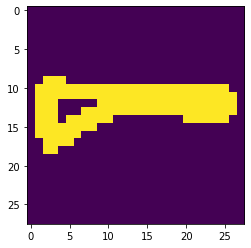

In [ ]:
idx = random.randint(0, len(x_test))
x_pred = np.reshape(x_test[idx],(1,28,28,1))
result = model.predict(x_pred)
index = np.argmax(result,axis =1)[0]
print("predicted as %s "%class_names[index])
print("Real is %s" %class_names[np.argmax(y_test[idx])])
plt.imshow(np.reshape(x_test[idx],(28,28)))

In [ ]:
def array_equal(arr1):
   empty_x = np.array([0. for i in range(arr1.shape[0])])
   comparison = arr1 == empty_x
   equal_arrays = comparison.all()
   return equal_arrays

In [ ]:
def resize_arr(arr):
  x1 = 0
  x2 = arr.shape[0]
  y1 = 0
  y2 = arr.shape[1]

  for i in range(arr.shape[0]):
    if not array_equal(arr[i,:]):
      x1 = i -1
      break;
  for i in range(arr.shape[0]-1,-1,-1):
    if not array_equal(arr[i,:]):
      x2 = i + 2 
      break;
  for j in range(arr.shape[1]):
    if not array_equal(arr[:,j]):
      y1 = j - 1
      break;
  for j in range(arr.shape[1]-1,-1,-1):
    if not array_equal(arr[:,j]):
      y2 = j + 2
      break;

  return arr[x1:x2,y1:y2]

In [ ]:
def padding(arr):
  max_shape = max(arr.shape)
  min_shape = min(arr.shape)
  padding = max_shape - min_shape

  if (max_shape == min_shape):
    return arr;

  elif (arr.shape[0] == max_shape):
    if padding % 2 == 1: 
      arr = np.pad(arr, ((0, 0), (padding//2 + 1, padding//2)))
    else:
      arr = np.pad(arr, ((0, 0), (padding//2, padding//2)))

  elif (arr.shape[1] == max_shape):
    if padding % 2 == 1: 
      arr = np.pad(arr, ((padding//2 + 1, padding//2), (0, 0)))
    else:
      arr = np.pad(arr, ((padding//2, padding//2), (0, 0)))
  return arr

(28, 28)


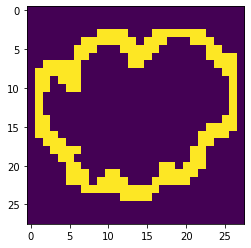

In [ ]:
def remove_alpha_channel(path):
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  img = rgba2rgb(img)
  img = np.array(img, dtype=np.float32)
  resized = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  resized[:,:] = 1 - resized[:,:]
  resized = black_and_white(resized)
  resized = resize_arr(resized)
  resized = padding(resized)
  resized = cv2.resize(resized, (26,26), interpolation = cv2.INTER_AREA)
  resized = black_and_white(resized)
  resized = np.pad(resized, ((1, 1), (1, 1)))
  return resized

tmp_resized = remove_alpha_channel('image.png')
plt.imshow(tmp_resized)
print(tmp_resized.shape)

In [ ]:
x_pred = np.reshape(tmp_resized,(1,28,28,1))
result = model.predict(x_pred)
index = np.argmax(result,axis =1)[0]
print(class_names[index],np.max(result,axis =1)[0]*100)

cloud 29.885834455490112


In [ ]:
with open('class_names.txt','w') as f:
  for i in range(len(class_names)):
    f.write(class_names[i] + '\n')

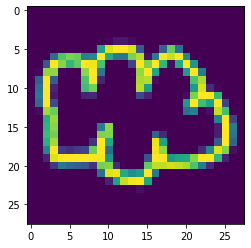

In [ ]:
tmp = np.load('dataset/cloud.npy')
plt.imshow(np.reshape(tmp[47885],(28,28)))